## Conduct the CNN model training based on the im2recipe image dataset and the topic modeling(NMF)

# This is the dataframe modified based on Chelsea's topic modeling

In [70]:
from google.colab import drive
drive.mount('/content/gdrive')
import os, csv
import json  
import pandas as pd
import numpy as np
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from operator import itemgetter
import operator
import pickle
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader 
import time
import copy
import torch.nn.functional as F

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
os.chdir("/content/gdrive/My Drive/2021 Summer CS7643 Share Folder/data/recipe1M")
layer1 = json.load(open("layer1.json", "r"))
layer2 = json.load(open("layer2.json", "r"))

In [ ]:
"""
# Train only
layer1_train = []
for i in range(len(layer1)):
  temp = {}
  if layer1[i]["partition"] == "train":
    temp["id"] = layer1[i]["id"]
    temp['title'] = layer1[i]['title']
    layer1_train.append(temp)
df_title_train = pd.DataFrame(layer1_train)

# Remove everything that is not alphanumeric or underscore
df_title_train['title_clean'] = df_title_train['title'].apply(lambda x: re.sub(r'[^\w]', ' ', x))

# Convert the titles to lowercase
df_title_train['title_clean'] = df_title_train['title_clean'].apply(lambda x: x.lower())
#len(set(df_title["title_clean"])) #790673 unique title vs. 
#df_title_train.to_csv("layer1_title_train.csv"))
"""

In [3]:
# Valid only
layer1_val = []
for i in range(len(layer1)):
  temp = {}
  if layer1[i]["partition"] == "val":
    temp["id"] = layer1[i]["id"]
    temp['title'] = layer1[i]['title']
    layer1_val.append(temp)
df_title_val = pd.DataFrame(layer1_val)

# Remove everything that is not alphanumeric or underscore
df_title_val['title_clean'] = df_title_val['title'].apply(lambda x: re.sub(r'[^\w]', ' ', x))

# Convert the titles to lowercase
df_title_val['title_clean'] = df_title_val['title_clean'].apply(lambda x: x.lower())
print(df_title_val)
#len(set(df_title["title_clean"])) #790673 unique title vs. 


                id  ...                                title_clean
0       00011e0b2c  ...                    steak   asparagus wraps
1       00011fc1f9  ...                     lentils vegetable soup
2       000128a538  ...                            harrison muesli
3       00025af750  ...   spanish spiked gazpacho in cucumber cups
4       00029df38f  ...                             praline kisses
...            ...  ...                                        ...
155031  fffe6545e6  ...  baked pasta with sausage and tomato pesto
155032  fffe89ea7e  ...                    fennel prawn conchiglie
155033  fffebe68b3  ...                        easy fattoush salad
155034  ffff03a753  ...                      kidney beans and corn
155035  ffffbb45d2  ...           baumkuchen    the king of cakes 

[155036 rows x 3 columns]


In [4]:
df_title_val.to_csv("layer1_title_val.csv")

In [5]:
# Generate the LDA model based on 20% of training data
stop_words = stopwords.words('english')
#may need to add more stop words such as recipe
stop_words.extend(['from', 'with', 'and', 'recipe', 'in', 'a', 's'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word.strip() for word in simple_preprocess(str(doc)) 
             if word.strip() not in stop_words] for doc in texts]
data = df_title_val["title_clean"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
#data_words[:20] # list if list with individual words in recipe title eg: ['worlds', 'best', 'mac', 'cheese']

"""
# stop words are removed completely
count = 0
for i in data_words:
  for word in i:
    if word in ["recipe", 'from', 'with', 'and', 'recipe', 'in', 'a', 's']:
      count += 1
print(count)
"""

'\n# stop words are removed completely\ncount = 0\nfor i in data_words:\n  for word in i:\n    if word in ["recipe", \'from\', \'with\', \'and\', \'recipe\', \'in\', \'a\', \'s\']:\n      count += 1\nprint(count)\n'

In [6]:
# rejoin the tokens to form strings which will be used to vectorize
#https://shravan-kuchkula.github.io/topic-modeling/#data-gathering-and-normalization 
#df = pd.read_csv("sub_train_title_LDA.csv")
#data_samples = df["title_clean"]
data_samples = [' '.join(item) for item in data_words]
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
tfidf = tfidf_vectorizer.fit_transform(data_samples) #tfidf.shape #(144128, 21930)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [7]:
n_topics = 300
nmf_300 = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, verbose=2, max_iter=5).fit(tfidf)

violation: 1.0
violation: 0.09097869529785488
violation: 0.04006592010450302
violation: 0.02146293049350556
violation: 0.011829907184339659


In [8]:
# Return Top X (here top 5) words per topic

def save_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_): 
      temp = {}
      temp["topic_id"] = topic_idx
      temp["topic_wd"] = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
      top_words.append(temp)
    top_words = pd.DataFrame(top_words)
    return top_words

df_tw = save_top_words(nmf_300, tfidf_feature_names, 5)
df_tw.head()

#May need to use the following for frequency check and further clean dataset
#word frequency quick check
#freq = df_tw["topic_wd"].str.split(expand=True).stack().value_counts()
#pd.DataFrame(freq).to_csv("ingr_freq.csv")

,topic_id,topic_wd
0,0,chicken wings breast dumplings buffalo
1,1,chocolate cake dark mousse covered
2,2,salad caesar dressing beet arugula
3,3,cauliflower soup cabbage tortellini minestrone
4,4,soup leek chilled hearty meatball


In [9]:
nmf_embedding = nmf_300.transform(tfidf) #W matitx 
# document membership weights across the k topics. Each row corresponds to a different document, and
#each column corresponds to a topic
#Shape: (144128, 300)
#Sorting the values gives us a ranking of the most relevant documents for each topic

violation: 1.0
violation: 0.02770199537023632
violation: 0.0033312607564281436
violation: 0.0008261872022965138
violation: 0.00023664700648482907


In [10]:
print(nmf_embedding.shape)

(155036, 300)


In [11]:
# 300 topic categories
# returns the most relavant recipe per topic
top_idx = np.argsort(nmf_embedding,axis=0)[-1:]
show_300 = 300
count_idxs = 0
final_names = data_words
topics_category_300 = []
for idxs in top_idx.T:
    if count_idxs == show_300: break
    for idx in idxs:
        #temp = (count_idxs,final_names[idx])
      temp = {}
      temp["topic_idx"] = count_idxs
      temp["topic"] = final_names[idx]
      topics_category_300.append(temp)

    count_idxs += 1
#topics_category_300
#df_tpc300.iloc[:10]
df_tpc300 = pd.DataFrame(topics_category_300)
# df_tpc300.to_csv("topics_category_300.csv")

'''
Manual evaluation may be required for 300 categories
'''

'\nManual evaluation may be required for 300 categories\n'

In [12]:
topics_category_300[26]

{'topic': ['muffins'], 'topic_idx': 26}

In [13]:
#Test 11th recipe
predict_id = 100
df_title_val.iloc[predict_id]["title_clean"] #baked beefy tomato rigatoni
#import operator
nmf_embedding[predict_id,:].round(2)
my_list = nmf_embedding[predict_id].round(2)
index, value = max(enumerate(my_list), key=operator.itemgetter(1))
index #20
topics_category_300[index] # ['baked', 'chicken'] 

{'topic': ['chicken'], 'topic_idx': 0}

In [ ]:
df_title_val.iloc[100]

id                   002c521113
title          Traditional Mead
title_clean    traditional mead
Name: 100, dtype: object

In [14]:
# THIS IS THE FINAL FUNCT FOR CATGORY PREDICTION
def get_top_cat_for_recipe(recipes_all_list, w_vector):
    final_recipes_cat_name = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() # no fitting category
        if all_zeros: recipe_cat_link.append(-1) # no fitting category
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] # 1. umdrehen 2. return erste
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: final_recipes_cat_name.append('no_cat')
        else: final_recipes_cat_name.append(topics_category_300[num])
    return final_recipes_cat_name

categories_for_recipes = get_top_cat_for_recipe(df_title_val["title_clean"], nmf_embedding)

In [15]:
df_title_val

,id,title,title_clean
0,00011e0b2c,Steak & Asparagus Wraps,steak asparagus wraps
1,00011fc1f9,Lentils Vegetable Soup,lentils vegetable soup
2,000128a538,Harrison Muesli,harrison muesli
3,00025af750,Spanish Spiked Gazpacho in Cucumber Cups,spanish spiked gazpacho in cucumber cups
4,00029df38f,Praline Kisses,praline kisses
...,...,...,...
155031,fffe6545e6,Baked Pasta With Sausage and Tomato Pesto,baked pasta with sausage and tomato pesto
155032,fffe89ea7e,Fennel-Prawn Conchiglie,fennel prawn conchiglie
155033,fffebe68b3,Easy Fattoush Salad,easy fattoush salad
155034,ffff03a753,Kidney Beans and Corn,kidney beans and corn


In [16]:
categories_for_recipes[0]
# len(categories_for_recipes)

{'topic': ['lettuce', 'wraps'], 'topic_idx': 299}

## Combine the orignal df with predicted recipe topic and index

In [17]:
df_topic_index = df_title_val.copy()

In [18]:
topic_list = []
topic_idx_list = []
for i in range(len(categories_for_recipes)):
  info = categories_for_recipes[i]
  if info == "no_cat":
    topic_list.append("No Cat")
    topic_idx_list.append("No Cat")
    continue
  topic_list.append(info["topic"])
  topic_idx_list.append(info["topic_idx"])


In [19]:
df_topic_index["topic"] = topic_list
df_topic_index["topic_idx_list"] = topic_idx_list

In [20]:
  df_topic_index

,id,title,title_clean,topic,topic_idx_list
0,00011e0b2c,Steak & Asparagus Wraps,steak asparagus wraps,"[lettuce, wraps]",299
1,00011fc1f9,Lentils Vegetable Soup,lentils vegetable soup,[soup],4
2,000128a538,Harrison Muesli,harrison muesli,No Cat,No Cat
3,00025af750,Spanish Spiked Gazpacho in Cucumber Cups,spanish spiked gazpacho in cucumber cups,"[spanish, steak, spanish, chicken]",291
4,00029df38f,Praline Kisses,praline kisses,"[chicken, pecan]",80
...,...,...,...,...,...
155031,fffe6545e6,Baked Pasta With Sausage and Tomato Pesto,baked pasta with sausage and tomato pesto,[pesto],17
155032,fffe89ea7e,Fennel-Prawn Conchiglie,fennel prawn conchiglie,"[fennel, coleslaw]",278
155033,fffebe68b3,Easy Fattoush Salad,easy fattoush salad,[salad],2
155034,ffff03a753,Kidney Beans and Corn,kidney beans and corn,"[corn, salad]",38


In [21]:
  df_mini = df_topic_index[0:1000]

## Traverse recipe id in df, find cooresponding image - create a dict {img_id : recipe id}

In [22]:
# input: recipe id, output: images.jpg(url could be printed here if needed)
def recipeid_to_image(recipe_id, print_url = False):
    images = []
    for food in layer2:
        if food.get("id") == recipe_id:
            image_list = food.get("images")
            for image in image_list:
                image_id = image.get("id")
                image_url = image.get("url")
                if print_url:
                    print(image_url) # this could be used for debug
                images.append(image_id)
            break
    return images

# input: recipe id, output: recipe details 
#                          (target_title, target_partition, target_url, target_ingredients, target_instructions)
def recipeid_to_details(recipe_id):
    target_ingredients = None
    target_url = None
    target_partition = None
    target_title = None
    target_instructions = None

    for recipe in layer1:
        if recipe.get("id") == recipe_id:
            target_ingredients = recipe.get("ingredients")
            target_url = recipe.get("url") 
            target_partition = recipe.get("partition")
            target_title = recipe.get("title") 
            target_instructions = recipe.get("instructions") 
            break
    return (target_title, target_partition, target_url, target_ingredients, target_instructions)
## layer_2 dict
def create_layer2_dict():
  layer2_dict = {}
  for food in layer2:
    recipe_id = food.get("id")
    image_list = food.get("images")
    image_names = []
    for image in image_list:
      image_names.append(image["id"])
    layer2_dict[recipe_id] = image_names
  return layer2_dict

def create_image_recipe_dict(this_df, layer2_dict):
    img_recipe_dict = {}
    for i in range(len(this_df)):
        # print(i)
        recipe_id = this_df.iloc[i]["id"]
        recipe_title = this_df.iloc[i]["title_clean"]
        recipe_topic = this_df.iloc[i]["topic"]
        recipe_topic_idx = this_df.iloc[i]["topic_idx_list"]
        # print(recipe_id)
        image_list = layer2_dict.get(recipe_id)
        # print(image_list)
        if image_list is None:
          continue
        for image in image_list:
            img_recipe_dict[image] = (recipe_id,recipe_title,recipe_topic,recipe_topic_idx )
        ## =========== remove this line or modify the number of recipes ==================
        # threshold = 100
        # if i > threshold:
        #   break
    return img_recipe_dict

In [23]:
# create dict first
layer2_dict = create_layer2_dict()

In [24]:
layer2_dict.get("394551a921")

['05d2b162a5.jpg',
 '54d5b6244a.jpg',
 '663e0deb9a.jpg',
 '67d4cd4c9d.jpg',
 '906b2517fe.jpg']

In [25]:
dict_mini = create_image_recipe_dict(df_mini, layer2_dict)

In [ ]:
dict_mini

In [27]:
# check if the image to recipe id matches or no
target_recipe = "00203e2b66"
image_list = recipeid_to_image(target_recipe, True)
recipe_details = recipeid_to_details(target_recipe)
print(image_list)
print("\n", recipe_details)

http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/10/65/29/piclQqgzw.jpg
http://img.sndimg.com/food/image/upload/w_512,h_512,c_fit,fl_progressive,q_95/v1/img/recipes/10/65/29/piclQ2Fga.jpg
['002de6dd0d.jpg', '5cce32cce0.jpg']

 ('Swedish Butter Cookies', 'val', 'http://www.food.com/recipe/swedish-butter-cookies-106529', [{'text': '1 cup butter, softened'}, {'text': '1 cup sugar'}, {'text': '2 teaspoons maple syrup'}, {'text': '2 cups all-purpose flour'}, {'text': '1 teaspoon baking soda'}, {'text': "2 tablespoons confectioners' sugar"}], [{'text': 'In a mixing bowl, cream butter and sugar.'}, {'text': 'Add maple syrup; mix well.'}, {'text': 'Combine the flour and baking soda; gradually add to the creamed mixture.'}, {'text': 'Divide the dough into eight portions; Roll each portion into a 9-inch log.'}, {'text': 'Place 3-inches apart on ungreased baking sheets.'}, {'text': 'Bake at 300F for 25 minutes or until lightly browned.'}, {'text': 'Cut 

In [28]:
target_recipe = "017452624d"
recipeid_to_image(target_recipe, True)

http://images.media-allrecipes.com/userphotos/256x256/2592498.jpg
http://images.media-allrecipes.com/userphotos/256x256/672683.jpg
http://images.media-allrecipes.com/userphotos/256x256/1033182.jpg
http://images.media-allrecipes.com/userphotos/256x256/1396112.jpg
http://images.media-allrecipes.com/userphotos/256x256/1396114.jpg
http://images.media-allrecipes.com/userphotos/256x256/1396111.jpg
http://images.media-allrecipes.com/userphotos/256x256/42984.jpg


['04ce282711.jpg',
 '3c54d77564.jpg',
 '6bc39c39c7.jpg',
 '823bf3dc42.jpg',
 'b4ee80f519.jpg',
 'b8bafe2205.jpg',
 'cbd761dcf2.jpg']

# Create all data frame which has image name & topic_idx

In [29]:
df_all_info = pd.DataFrame(index = range(0, len(dict_mini)), columns=['Image name','Recipe ID','Title','Topic','Topic Index'])

In [30]:
df_all_info

,Image name,Recipe ID,Title,Topic,Topic Index
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
769,NaN,NaN,NaN,NaN,NaN
770,NaN,NaN,NaN,NaN,NaN
771,NaN,NaN,NaN,NaN,NaN
772,NaN,NaN,NaN,NaN,NaN


In [31]:
index = 0
for key in dict_mini:
  df_all_info.iloc[index]["Image name"] = key
  value = dict_mini.get(key)
  df_all_info.iloc[index]["Recipe ID"] = value[0]
  df_all_info.iloc[index]["Title"] = value[1]
  df_all_info.iloc[index]["Topic"] = value[2]
  df_all_info.iloc[index]["Topic Index"] = value[3]
  index += 1

In [32]:
df_all_info

,Image name,Recipe ID,Title,Topic,Topic Index
0,665bbeafc7.jpg,00029f71f7,apple carrot bones dog treat,"[carrot, salad]",98
1,87aea5035b.jpg,00029f71f7,apple carrot bones dog treat,"[carrot, salad]",98
2,a97924d704.jpg,0004c091a0,whole wheat waffles,"[whole, wheat]",122
3,8e98aee7e1.jpg,000507ca6b,frosty strawberry squares,"[cheese, squares]",188
4,7027a5c4f9.jpg,0006354bc3,irresistible peanut butter cookies,"[peanut, butter]",10
...,...,...,...,...,...
769,be869ea3a0.jpg,01a51a098a,vibrant rainbow cake,[cake],92
770,c4c632921f.jpg,01a51a098a,vibrant rainbow cake,[cake],92
771,c990d54ae3.jpg,01a51a098a,vibrant rainbow cake,[cake],92
772,eabf72c962.jpg,01a51a098a,vibrant rainbow cake,[cake],92


In [33]:
df_all_info_with_cat = df_all_info[df_all_info.Topic != "No Cat"]

In [49]:
df_all_info_with_cat[0:20]

,Image name,Recipe ID,Title,Topic,Topic Index
0,665bbeafc7.jpg,00029f71f7,apple carrot bones dog treat,"[carrot, salad]",98
1,87aea5035b.jpg,00029f71f7,apple carrot bones dog treat,"[carrot, salad]",98
2,a97924d704.jpg,0004c091a0,whole wheat waffles,"[whole, wheat]",122
3,8e98aee7e1.jpg,000507ca6b,frosty strawberry squares,"[cheese, squares]",188
4,7027a5c4f9.jpg,0006354bc3,irresistible peanut butter cookies,"[peanut, butter]",10
5,fff3e1751a.jpg,0006354bc3,irresistible peanut butter cookies,"[peanut, butter]",10
6,1fd9fdddd4.jpg,00081bb5ef,joe s pasta e fagiolo,[pasta],24
7,0c901c0aee.jpg,000875a149,vietnamese chicken wings,[chicken],0
8,15b1881e50.jpg,000875a149,vietnamese chicken wings,[chicken],0
9,cc7ca17a88.jpg,00089c3010,easy italian style chili,"[chicken, italian, style]",65


In [ ]:
####### IMPORTANT LIST FOR TRAINING ##########
img_array_list = []
label_list = []
img_dir = "/content/gdrive/My Drive/2021 Summer CS7643 Share Folder/data/images/val"
############################################
def read_image(image_dir, target_img_name):
  first_dir = target_img_name[0]
  second_dir = target_img_name[1]
  third_dir = target_img_name[2]
  forth_dir = target_img_name[3]
  final_img_dir = image_dir + "/" + first_dir + "/" + second_dir + "/" + third_dir + "/" + forth_dir + "/" + target_img_name
  img = plt.imread(final_img_dir)
  return img



# traverse all row in df_mini_batch and append the image array & title into list
for i in range(df_all_info_with_cat.shape[0]):
  #print(i)
  selected_row = df_all_info_with_cat.iloc[i] # select ith row in df_mini_batch
  selected_label = selected_row["Topic Index"]
  selected_img_name = selected_row["Image name"]
  img_array = read_image(img_dir, selected_img_name) # return a (h,w,channel) np array
  # append into list
  img_array_list.append(img_array)
  label_list.append(selected_label)

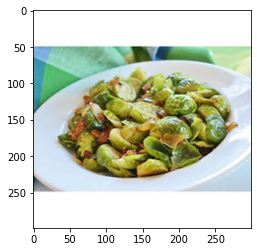

In [66]:
# Create data for training from the list
my_x = np.zeros((len(img_array_list), 299, 299, 3)) # Inception accepts (299,299,3) image
for i in range(len(img_array_list)):
  #print(img.shape)
  img_new = cv2.resize(img_array_list[i], dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
  #print(img_new.shape)
  my_x[i] = img_new
#my_x = my_x.astype(int)
plt.imshow(my_x[100].astype(int))

In [136]:
label = np.zeros((df_all_info_with_cat.shape[0], 1))
#for i in range(df_all_info_with_cat.shape[0]):
#  label[i] = df_all_info_with_cat["Topic Index"][i]
#  print(i, label[i])
i = 0
for index, row in df_all_info_with_cat.iterrows():
    label[i] = df_all_info_with_cat["Topic Index"][index]
    #print(i,label[i])
    i += 1
label = label.astype(int)
print(label[17])

[153]


In [132]:
label_encoded = F.one_hot(torch.tensor(label), num_classes=300)

In [116]:
# https://stackoverflow.com/questions/65594383/how-to-convert-dataset-of-images-to-tensor/65594790
# Self define a class which iterates over the dataset
class im2recipedataset(torch.utils.data.Dataset):
    def __init__(self, img_array, label_array):
      # load the dataset
      self.dataset = img_array
      self.label = label_array
  
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label[idx]
                
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return transform(data), label

    def __len__(self):
        return len(self.dataset)

In [182]:
train_set = im2recipedataset(my_x,label)
valid_set = im2recipedataset(my_x,label)
Data, label0 = train_set.__getitem__(0)

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=64, shuffle=True)
dataloaders_dict = {"train":train_dataloader, "val": valid_dataloader}

In [175]:
# ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxilary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299

    return model_ft, input_size
#  Flag for feature extracting. When False, we finetune the whole model,
#  when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
InceptionV3, input_size = initialize_model(300, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(InceptionV3)

In [176]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Send the model to GPU
InceptionV3 = InceptionV3.to(device)

cuda:0


In [177]:
params_to_update = InceptionV3.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in InceptionV3.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [178]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [179]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                inputs = inputs.type(torch.cuda.FloatTensor)
                #print(inputs.shape)
                labels = torch.squeeze(labels)
                labels = labels.to(device)
                #print(labels.shape)
                #outputs, aux_outputs = model(inputs)
                #print(outputs.shape)
                #print(aux_outputs.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [180]:
num_epochs = 70
# Train and evaluate
model_ft, hist = train_model(InceptionV3, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=True)

Epoch 0/69
----------
train Loss: 8.0073 Acc: 0.0079
val Loss: 5.6232 Acc: 0.0118

Epoch 1/69
----------
train Loss: 7.8514 Acc: 0.0157
val Loss: 5.4482 Acc: 0.0354

Epoch 2/69
----------
train Loss: 7.6105 Acc: 0.0380
val Loss: 5.2859 Acc: 0.0459

Epoch 3/69
----------
train Loss: 7.4149 Acc: 0.0485
val Loss: 5.1573 Acc: 0.0472

Epoch 4/69
----------
train Loss: 7.2785 Acc: 0.0459
val Loss: 5.0613 Acc: 0.0550

Epoch 5/69
----------
train Loss: 7.1280 Acc: 0.0590
val Loss: 4.9850 Acc: 0.0708

Epoch 6/69
----------
train Loss: 7.0601 Acc: 0.0708
val Loss: 4.9188 Acc: 0.0917

Epoch 7/69
----------
train Loss: 6.9443 Acc: 0.0799
val Loss: 4.8625 Acc: 0.1075

Epoch 8/69
----------
train Loss: 6.8769 Acc: 0.0917
val Loss: 4.8093 Acc: 0.1153

Epoch 9/69
----------
train Loss: 6.8029 Acc: 0.0944
val Loss: 4.7632 Acc: 0.1298

Epoch 10/69
----------
train Loss: 6.7263 Acc: 0.1127
val Loss: 4.7177 Acc: 0.1376

Epoch 11/69
----------
train Loss: 6.6700 Acc: 0.1140
val Loss: 4.6737 Acc: 0.1429

Ep

In [160]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input.shape)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target.shape)
#output = loss(input, target)
#output.backward()

torch.Size([3, 5])
torch.Size([3])
